## Problem: Time-Fractional Diffusion Equation

We solve the equation:

$$
\frac{\partial^\alpha u(x, t)}{\partial t^\alpha} = \kappa \frac{\partial^2 u(x, t)}{\partial x^2}
$$

with:

- **Sinusoidal initial condition**: $u(x,0) = sin (\frac{\pi}{L} m x)$
- **Dirichlet boundary conditions**: $u(-L/2,t) = 0$, $u(L/2,t) = 0$
- **Caputo fractional derivative** of order $\alpha$

In [1]:
# Step 1: Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import time

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.size'] = 12

In [13]:
#Parameters
alpha = 0.5      # Fractional order (0 < α ≤ 1)
kappa = 1      # Diffusion coefficient
L = 2.0          # Domain length: [-L/2, L/2] = [-1, 1]
T = 2          # Final time

# Discretization parameters
M = 50         # Number of spatial points
N = 1000          # Number of time steps

# Sinusoidal parameters
m = 1

In [14]:
#Spatial and Temporal grids
h = L / (M-1)          # Spatial step size
tau = T / N              # Time step size
x = np.linspace(0, L, M)  # Spatial grid
t = np.linspace(0, T, N+1)     # Temporal grid

# Gamma function value for the L1 scheme
Gamma_alpha = math.gamma(2 - alpha)

# Discretization parameter μ
mu = kappa * (tau**alpha) * Gamma_alpha / (h**2)

print("\nGrid parameters:")
print(f"Spatial step h = {h:.6f}")
print(f"Time step τ = {tau:.6f}")
print(f"Γ(2-α) = {Gamma_alpha:.6f}")
print(f"Discretization parameter μ = {mu:.6f}")


Grid parameters:
Spatial step h = 0.040816
Time step τ = 0.002000
Γ(2-α) = 0.886227
Discretization parameter μ = 23.789872


In [15]:
# Sinusoidal initial condition
def initial_condition(x, m=1):
        return np.sin(np.pi / L * m * x)

# Dirichlet boundary conditions (homogeneous)
def boundary_conditions(t):
    """u(-L/2,t) = 0, u(L/2,t) = 0"""
    return 0.0, 0.0

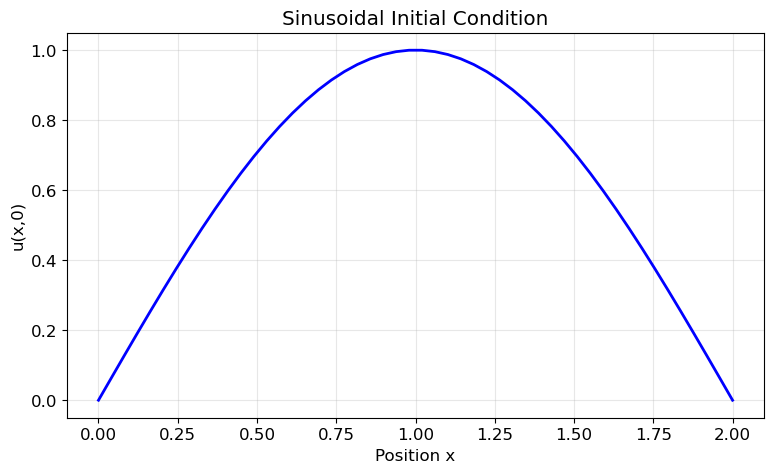

In [19]:
# Set initial condition
u_initial = initial_condition(x, 1)
u_initial[0] = 0.0
u_initial[-1] = 0.0

# Plot initial condition
plt.plot(x, u_initial, 'b-', linewidth=2)
plt.xlabel('Position x')
plt.ylabel('u(x,0)')
plt.title('Sinusoidal Initial Condition')
plt.grid(True, alpha=0.3)
plt.show()


In [20]:
# L1 scheme coefficients for Caputo derivative
def compute_L1_coefficients(n, alpha):
    b = np.zeros(n)
    for j in range(n):
        b[j] = (j + 1)**(1 - alpha) - j**(1 - alpha)
    return b

In [21]:
def thomas_algorithm(a, b, c, d):
    n = len(d)
    a = a.astype(float)
    b = b.astype(float)
    c = c.astype(float)
    d = d.astype(float)
    
    # forward
    c_prime = np.zeros(n, dtype=float)
    d_prime = np.zeros(n, dtype=float)
    
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]
    
    for i in range(1, n):
        denom = b[i] - a[i] * c_prime[i-1]
        c_prime[i] = c[i] / denom if i < n - 1 else 0.0
        d_prime[i] = (d[i] - a[i] * d_prime[i-1]) / denom
    
    
    # Back substitution
    x = np.zeros(n, dtype=float)
    x[-1] = d_prime[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x

In [22]:
def compute_H(u, n, alpha):
    M = u.shape[0]
    H = np.zeros(M, dtype=float)

    if n == 1:
        # no history sum
        H[:] = u[:, 0].astype(float)
    else:
        b_coeffs = compute_L1_coefficients(n, alpha)  # length n, b_coeffs[0]=1
        # sum k=1..n-1 (use b_coeffs[k])
        # vectorized implementation for speed:
        hist = np.zeros((M,), dtype=float)
        for k in range(1, n):
            contrib = b_coeffs[k] * (u[:, n - k] - u[:, n - k - 1])
            hist += contrib
        H[:] = u[:, n - 1] - hist

    return H

In [23]:
def solve_time_step_interior(u_prev_full, H_full, mu, a_tn, b_tn):
    M = len(u_prev_full)
    # number of interior unknowns
    n_int = M - 2
    if n_int <= 0:
        raise ValueError("Need at least 3 spatial points for interior solve.")

    # Tridiagonal for interior (size n_int)
    a = -mu * np.ones(n_int)    # lower diag 
    b = (1.0 + 2.0 * mu) * np.ones(n_int)
    c = -mu * np.ones(n_int)    # upper diag
    a[0] = 0

    # Right-hand side is H at interior points with BC contributions
    d = H_full[1:-1].copy()     # interior nodes H_i

    # Add boundary contributions (from Laplacian discretization)
    d[0] += mu * a_tn      # left boundary contributes to first interior equation
    d[-1] += mu * b_tn     # right boundary contributes to last interior equation

    # Solve the interior system
    u_int = thomas_algorithm(a, b, c, d)

    # assemble full vector
    u_new = np.empty(M, dtype=float)
    u_new[0] = a_tn
    u_new[-1] = b_tn
    u_new[1:-1] = u_int

    return u_new

In [24]:
def solve_fractional_diffusion(alpha, kappa, L, T, M, N, m):
    """
    Complete solver for time-fractional diffusion equation
    """
    # Start timing
    start_time = time.time()
    
    
    # Set up grid and parameters
    h = L / (M - 1)
    tau = T / N
    x = np.linspace(0, L, M)
    Gamma_alpha = math.gamma(2 - alpha)
    mu = kappa * (tau**alpha) * Gamma_alpha / (h**2)

    # Set initial condition
    u = np.zeros((M, N+1))
    u[:, 0] = initial_condition(x, m)
    u[0,:] = 0.0
    u[-1,:] = 0.0
    
    
    # inside solve_fractional_diffusion loop:
    for n in range(1, N+1):
        current_time = n * tau
        a_tn, b_tn = boundary_conditions(current_time)

        H = compute_H(u, n, alpha)   # u has shape (M, N+1)
        # Solve for full new vector using interior solver
        u_new = solve_time_step_interior(u[:, n-1], H, mu, a_tn, b_tn)

        # store
        u[:, n] = u_new

    # End timing
    end_time = time.time()
    computation_time = end_time - start_time
    
    print(f"\nComputation completed in {computation_time:.2f} seconds")
    
    return x, np.linspace(0, T, N+1), u

In [25]:
# Plot solution at different times
def plot_solution_times(x, u,t, time_indices, title):
    """Plot solution at specific time indices"""
    
    for idx in time_indices:
        t_val = t[idx]
        if idx == 0:
            label = f't = 0.000 (Initial)'
        elif idx == len(t) - 1:
            label = f't = {t_val:.3f} (Final)'
        else:
            label = f't = {t_val:.3f}'
        
        plt.plot(x, u[:, idx], linewidth=2, label=label)
    
    plt.xlabel('Position x')
    plt.ylabel('Solution u(x,t)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [26]:
# Mass conservation analysis
def analyze_mass_conservation(x, u, t):
    """Analyze mass conservation over time"""
    mass = np.zeros(len(t))
    for n in range(len(t)):
        mass[n] = np.trapz(u[:, n], x)
    
    plt.plot(t, mass, 'b-', linewidth=2)
    plt.xlabel('Time t')
    plt.ylabel('Total Mass ∫u(x,t)dx')
    plt.title('Mass Conservation Analysis')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial mass: {mass[0]:.6f}")
    print(f"Final mass: {mass[-1]:.6f}")
    print(f"Mass change: {abs(mass[-1] - mass[0]):.6e}")
    print(f"Relative mass change: {abs(mass[-1] - mass[0])/mass[0]:.6e}")

# Maximum value analysis
def analyze_maximum_values(u,t):
    """Analyze how the maximum value evolves over time"""
    max_vals = np.max(u, axis=0)
    

    plt.semilogy(t, max_vals, 'r-', linewidth=2)
    plt.xlabel('Time t')
    plt.ylabel('Maximum Value max(u(x,t))')
    plt.title('Evolution of Maximum Value (Log Scale)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial maximum: {max_vals[0]:.6f}")
    print(f"Final maximum: {max_vals[-1]:.6f}")
    print(f"Decay factor: {max_vals[-1]/max_vals[0]:.6f}")

In [27]:
x_sol1, t_sol1, u_sol1 = solve_fractional_diffusion(1,kappa,L,T,M,N,m)


Computation completed in 1.99 seconds


In [28]:
x_sol5, t_sol5, u_sol5 = solve_fractional_diffusion(0.5,kappa,L,T,M,N,m)


Computation completed in 2.10 seconds


In [29]:
x_sol3, t_sol3, u_sol3 = solve_fractional_diffusion(0.3,kappa,L,T,M,N,m)


Computation completed in 2.12 seconds


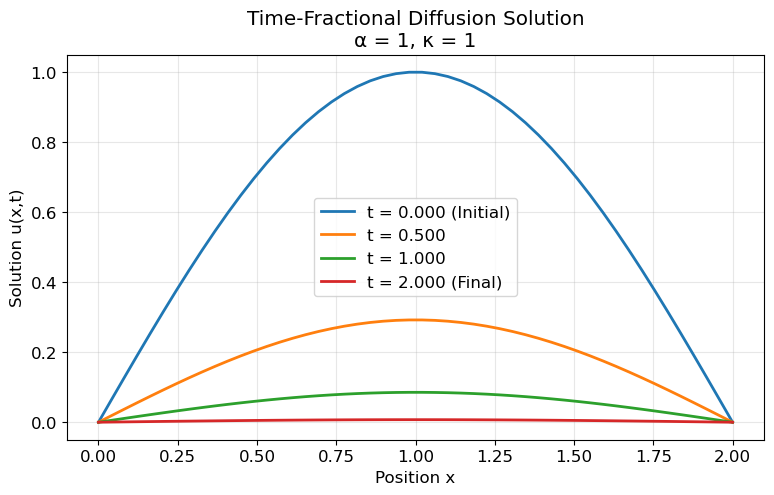

In [30]:
# Plot for alpha = 1
time_indices = [0, N//4,N//2,N]
plot_solution_times(x_sol1, u_sol1,t_sol1, time_indices, 
                   f'Time-Fractional Diffusion Solution\nα = {1}, κ = {kappa}')

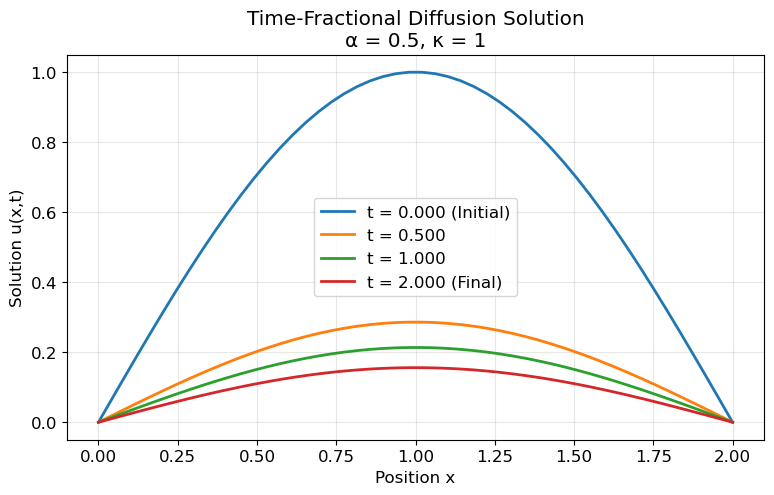

In [31]:
# Plot for alpha = 0.5
time_indices = [0, N//4,N//2,N]
plot_solution_times(x_sol5, u_sol5,t_sol5, time_indices, 
                   f'Time-Fractional Diffusion Solution\nα = {0.5}, κ = {kappa}')

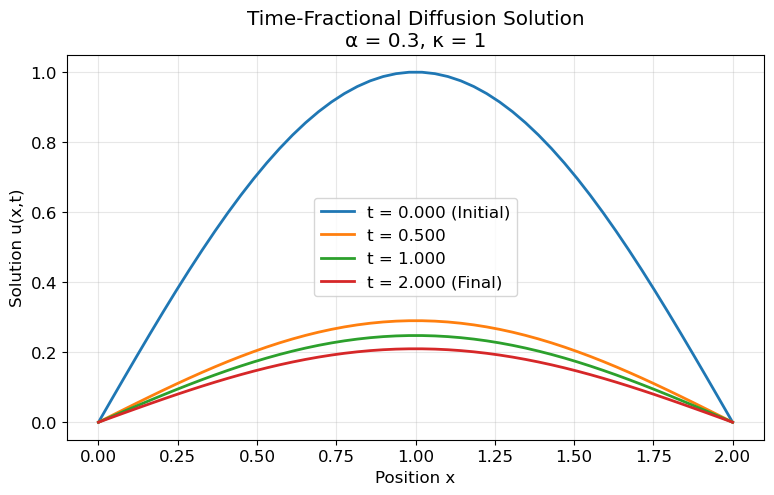

In [32]:
# Plot for alpha = 0.3
time_indices = [0, N//4,N//2,N]
plot_solution_times(x_sol3, u_sol3,t_sol3, time_indices, 
                   f'Time-Fractional Diffusion Solution\nα = {0.3}, κ = {kappa}')

## Compare solutions for different fractional orders α

In [34]:
def compare_different_alpha(t_sp):
    """Compare solutions for different fractional orders α"""
    alphas = [0.3, 0.5, 0.7, 1.0]
    solutions = []
    
    for alpha_comp in alphas:
        print(f"Solving for α = {alpha_comp}...")
        x_sol, t_sol, u_comp = solve_fractional_diffusion(alpha_comp, kappa, L, t_sp, M, N, m)
        solutions.append(u_comp)
        
        # Plot final time solution
        plt.plot(x_sol, u_comp[:, -1], linewidth=2, 
                label=f'α = {alpha_comp}')
    
    plt.xlabel('Position x')
    plt.ylabel('Solution u(x,T)')
    plt.title(f'Comparison of Different α Values at t = {t_sp}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return alphas, solutions

Solving for α = 0.3...

Computation completed in 2.08 seconds
Solving for α = 0.5...

Computation completed in 1.87 seconds
Solving for α = 0.7...

Computation completed in 1.83 seconds
Solving for α = 1.0...

Computation completed in 1.79 seconds


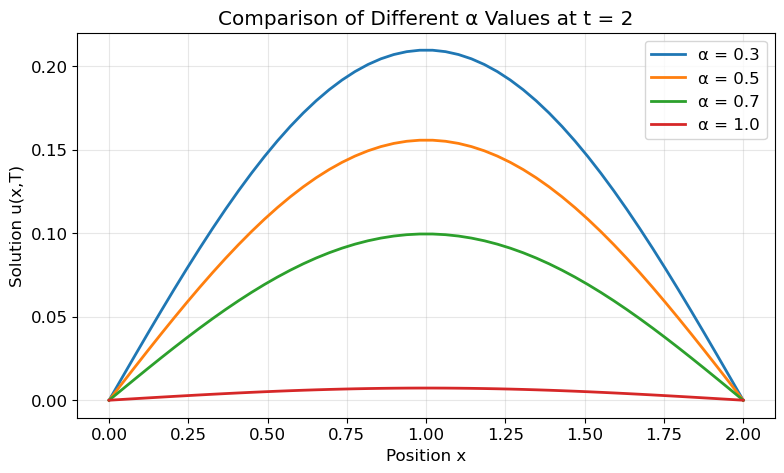

In [35]:
#At t = 2
alphas_comp, solutions_comp = compare_different_alpha(2)